# Import Libraries

In [55]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [56]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples),                                                                                  # therefore you should add a comma after the values. 
                                                                                  # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [57]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [58]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=0, bias=0),     #Input-1x28x28      Output-32x26x26    RF-3
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=0, bias=0),    #Input-32x26x26    Output-64x24x24    RF-5
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                         #Input-64x24x24    Output-64x12x12    RF-10
            
            
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=0, bias=0),      #Input-64x12x12    Output-128x10x10    RF-12
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1, bias=0),    #Input-128x10x10    Output-256x10x10      RF-14
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                             #Input-256x10x10      Output-256x5x5    RF-28 
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1, bias=0),    #Input-256x5x5    Output-512x5x5    RF-30
            nn.ReLU() 
        )
        
        self.avgpool = nn.AvgPool2d(5)                  #Input-512x5x5    Output-512x1x1

        self.out = nn.Sequential(
            nn.Conv2d(512, 10, 1, bias=0)               #Input-512x1x1    Output-10x1x1
        )        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        x = self.out(x)
        x = x.squeeze()
        x = F.log_softmax(x, dim=1)
        return x

In [60]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

You should consider upgrading via the '/home/sahil/miniconda3/envs/deeplearning/bin/python -m pip install --upgrade pip' command.
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6          [-1, 128, 10, 10]          73,728
              ReLU-7          [-1, 128, 10, 10]               0
            Conv2d-8          [-1, 256, 10, 10]         294,912
              ReLU-9          [-1, 256, 10, 10]               0
        MaxPool2d-10            [-1, 256, 5, 5]               0
           Conv2d-11            [-1, 512, 5, 5]       1,179,648
             ReLU-12            

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [61]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [62]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]EPOCH: 0
Loss=0.10089252144098282 Batch_id=468 Accuracy=45.66: 100%|██████████| 469/469 [00:15<00:00, 29.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.1922, Accuracy: 9420/10000 (94.20%)

EPOCH: 1
Loss=0.0566600076854229 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.1043, Accuracy: 9679/10000 (96.79%)

EPOCH: 2
Loss=0.06702905893325806 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0513, Accuracy: 9814/10000 (98.14%)

EPOCH: 3
Loss=0.0440649650990963 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0480, Accuracy: 9828/10000 (98.28%)

EPOCH: 4
Loss=0.04595579579472542 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:15<00:0

# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

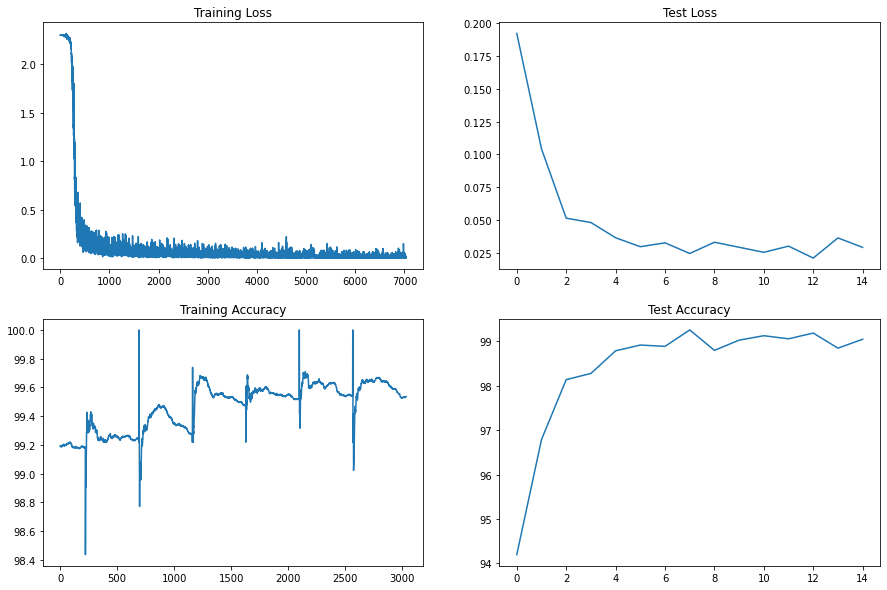

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")